In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
from typing import Optional, List, Dict, Any

from panovlm.model import PanoramaVLM
from panovlm.processors.image import PanoramaImageProcessor

def denormalize(tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    tensor = tensor.clone().permute(1, 2, 0).numpy()
    tensor = std * tensor + mean
    tensor = np.clip(tensor, 0, 1)
    return tensor

def visualize_views(
    pixel_values: torch.Tensor,
    title: str,
    *,  # [핵심 수정] 이 뒤의 인자는 반드시 키워드로만 전달해야 함
    titles: Optional[List[str]] = None,
    filename: Optional[str] = None,
    show_plot: bool = False
):
    """
    Create and save or show a visualization of the processed views.
    Optional arguments after '*' must be passed as keyword arguments.
    """
    if not filename and not show_plot:
        print("Warning: No action taken. Either 'filename' must be provided or 'show_plot' must be True.")
        return

    views = pixel_values.squeeze(0)
    num_views = views.shape[0]
    
    if num_views <= 4:
        nrows, ncols = 1, num_views
    else:
        nrows = 2
        ncols = math.ceil(num_views / 2)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4 + 1))
    axes = np.ravel(axes)
    
    fig.suptitle(title, fontsize=16)
    
    for i in range(num_views):
        view_tensor = views[i]
        img = denormalize(view_tensor)
        axes[i].imshow(img)
        axes[i].axis('off')
        if titles and i < len(titles):
            axes[i].set_title(titles[i])

    for i in range(num_views, len(axes)):
        axes[i].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    if filename:
        plt.savefig(filename)
        print(f"Saved visualization to {filename}")
    
    if show_plot:
        plt.show()

    plt.close(fig)

checkpoint_path = 'runs/siglipv2qwen25Instruct_e2p_finetune_mlp/best_v1.ckpt'
# 설정 시스템을 통한 모델 로딩
model = PanoramaVLM.from_checkpoint(checkpoint_path, device="auto")
model.eval()

sample_image = "data/quic360/downtest/images/26286679561_2bc4360f7d_f.jpg"
sample_text = "이 사진에서 가장 눈에 띄는 것은 무엇인가요?"

/data/3_lib/miniconda3/envs/panovlm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🚀 PanoramaVLM 체크포인트 로딩: runs/siglipv2qwen25Instruct_e2p_finetune_mlp/best_v1.ckpt
📂 체크포인트 로딩 중...


/data/1_personal/4_SWWOO/panollava/panovlm/model.py:1347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device_obj)


🔍 설정 파일 감지 실패 - 하이퍼파라미터에서 생성
🛠️  모델 파라미터:
   - vision_name: google/siglip-base-patch16-224
   - language_model_name: Qwen/Qwen2.5-0.5B-Instruct
   - resampler_type: mlp
   - latent_dimension: 768
   - vicreg_loss_weight: 0.0
   - vicreg_overlap_ratio: 0.5
   - max_text_length: 256
   - config: ModelConfig(vision=google/siglip-base-patch16-224, language=Qwen/Qwen2.5-0.5B-Instruct, dim=768)
🏗️  모델 인스턴스 생성 중...
[Model] Using provided ModelConfig: ModelConfig(vision=google/siglip-base-patch16-224, language=Qwen/Qwen2.5-0.5B-Instruct, dim=768)
[Tokenizer Setup] Warning: No bos_token defined
[Tokenizer Setup] Warning: No unk_token defined
[Tokenizer Setup] Added 1 special tokens: ['<|vision|>', '<|endoftext|>']
[Tokenizer Setup] Resized embeddings: 151936 -> 151666
[TextFormatter] Detected: qwen2.5 (Instruct)
[TextFormatter] Assistant start: '<|im_start|>assistant
'
[Model] Initialized UniversalTextFormatter for qwen2.5
⚙️  가중치 로딩 중...
   - 로드된 키: 512
🔍 LoRA 가중치 자동 감지: runs/siglipv2qwen25Ins

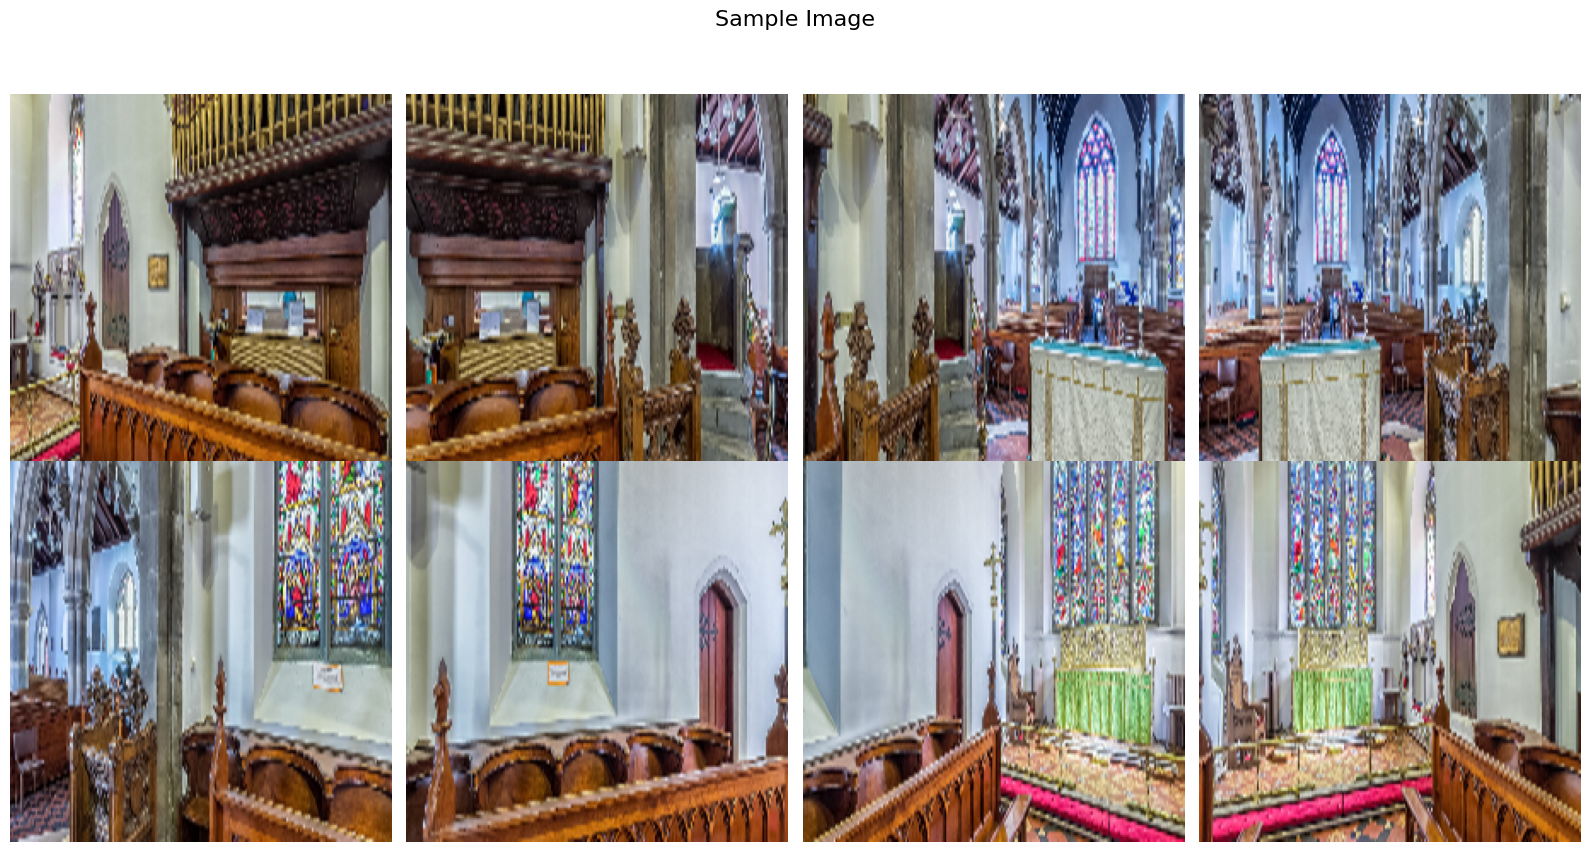

In [2]:

img_proc = PanoramaImageProcessor(
    image_size    =(224, 224),
    crop_strategy ="e2p",   # 또는 "e2p" / "cubemap" /"anyres"/"sliding_window"
    fov_deg       =90,
    overlap_ratio =0.5,
    normalize= True,
    anyres_max_patches=8
)

img = img_proc(sample_image)
img = img.unsqueeze(0)  # 배치 차원 추가
visualize_views(img, title="Sample Image", show_plot=True)

In [3]:
batch_size, num_views, normalized_pixels = model._normalize_pixel_values(img.cuda())
print(f"Batch size: {batch_size}, Number of views: {num_views}, Normalized pixels shape: {normalized_pixels.shape}")

last_hidden_states = model._extract_vision_features(
    pixel_values=normalized_pixels,
    batch_size=batch_size,
    num_views=num_views
)
print(f"Last hidden states shape: {last_hidden_states.shape}")
last_hidden_states = last_hidden_states.cpu().detach().numpy()

Batch size: 1, Number of views: 8, Normalized pixels shape: torch.Size([1, 8, 3, 224, 224])
Last hidden states shape: torch.Size([8, 196, 768])


In [ ]:
from panovlm.vis.dino import DinoVisualizer
visualizer = DinoVisualizer(last_hidden_states,remove_cls_token=False)
visualizer.fit_pca(use_global_scaling=True)
visualizer.get_hidden_similarity()
metadata = img_proc.view_metadata  # E2P에서 자동 생성
similarity = visualizer.get_hidden_similarity(
    pairs=[(0, 1)], view_metadata=metadata
)
visualizer.plot_pca_results(
    titles=checkpoint_path.split("/")[1],
    save_path=f"{checkpoint_path.split("/")[1]}.png",
    )
visualizer.plot_phi_bin_analysis(view_metadata=metadata)
visualizer.plot_seam_analysis(seam_width=2)

PCA 모델 학습 및 RGB 변환 완료. (공통 스케일링: True)
▶ Hidden-space 유사도 (MSE, Cosine, CKA, Hungarian, Warp-OCS):
  Pair (0, 1): MSE=1.6639, Cos=0.1680, CKA=0.7791, Hung=0.7232
  Pair (1, 2): MSE=1.5735, Cos=0.2132, CKA=0.7636, Hung=0.5964
  Pair (2, 3): MSE=1.4682, Cos=0.2659, CKA=0.7368, Hung=0.8514
  Pair (3, 4): MSE=1.3874, Cos=0.3063, CKA=0.7343, Hung=0.6034
  Pair (4, 5): MSE=1.1352, Cos=0.4324, CKA=0.7744, Hung=0.6723
  Pair (5, 6): MSE=1.2789, Cos=0.3606, CKA=0.6937, Hung=0.7002
  Pair (6, 7): MSE=1.5048, Cos=0.2476, CKA=0.6595, Hung=0.7709
  Pair (7, 0): MSE=1.5591, Cos=0.2204, CKA=0.7324, Hung=0.6145
▶ Hidden-space 유사도 (MSE, Cosine, CKA, Hungarian, Warp-OCS):
  Pair (0, 1): MSE=1.6639, Cos=0.1680, CKA=0.7791, Hung=0.7232, OCS=0.2672
시각화 저장: siglipv2qwen25Instruct_e2p_finetune_mlp.png
